In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

### Accept-Reject Methods: Uniform Sampling in a Larger Set

While the Fundamental Theorem of Simulation is foundational, its practical application often requires additional steps. Direct simulation of the uniform pair $(X, U)$ is not always straightforward. For instance:
- Simulating $X \sim f(x)$ and $U \sim U(0, f(x))$ makes the representation impractical.
- Simulating $U$ from its marginal distribution and then $X$ from the conditional distribution $f(x|U=u)$ is often infeasible.

The solution involves simulating the entire pair $(X, U)$ within a larger set, where simulation is easier. Once the pair is generated, we only accept it if it satisfies the desired constraint.

#### Simulating the Pair $(Y, U)$
In a one-dimensional setting, suppose:
- $ \int_a^b f(x) \, dx = 1 $
- $ f(x) $ is bounded by $ m $.

We can simulate $(Y, U)$ as follows:
1. Generate $Y \sim U(a, b)$.
2. Generate $U \sim U(0, m)$.
3. Accept the pair $(Y, U)$ if $ 0 < U < f(Y) $.

This results in the correct distribution of $Y$, now denoted $X$, because:

$$
P(X \leq x) = P(Y \leq x \, | \, U < f(Y))
= \int_a^x \int_0^{f(y)} \frac{1}{m(b-a)} \, du \, dy 
= \int_a^x f(y) \, dy.
$$

Thus, if $A \subseteq B$ and we generate a uniform sample on $B$, keeping only the samples in $A$ results in a uniform sample on $A$ with random size.

#### Example : Beta Distribution Simulation

Simulating Beta random variables directly can be challenging, but Theorem 2.15 provides an effective approach when $a \geq 1$ and $b \geq 1$. To generate $X \sim \text{Beta}(a, b)$:
1. Generate $Y \sim U(0, 1)$.
2. Generate $U \sim U(0, m)$, where $m$ is the maximum value of the Beta density (determined numerically or analytically).
3. Accept $X = Y$ if $U < f(Y)$, where $f(Y)$ is the Beta density function.

The probability of acceptance is:

$$
P(\text{Accept}) = \frac{1}{m} \int_a^b f(y) \, dy = \frac{1}{m}.
$$

For instance, in Example 2.16, with $a = 2.7$ and $b = 6.3$, $m = 2.67$. Thus, approximately $ \frac{1}{2.67} \approx 37\% $ of the pairs are accepted.

---

#### Visualization of Beta Simulation
Below is a visualization of the Accept-Reject method applied to the Beta distribution:

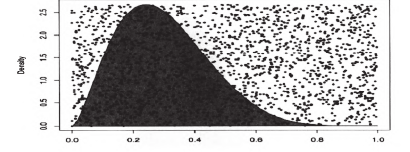


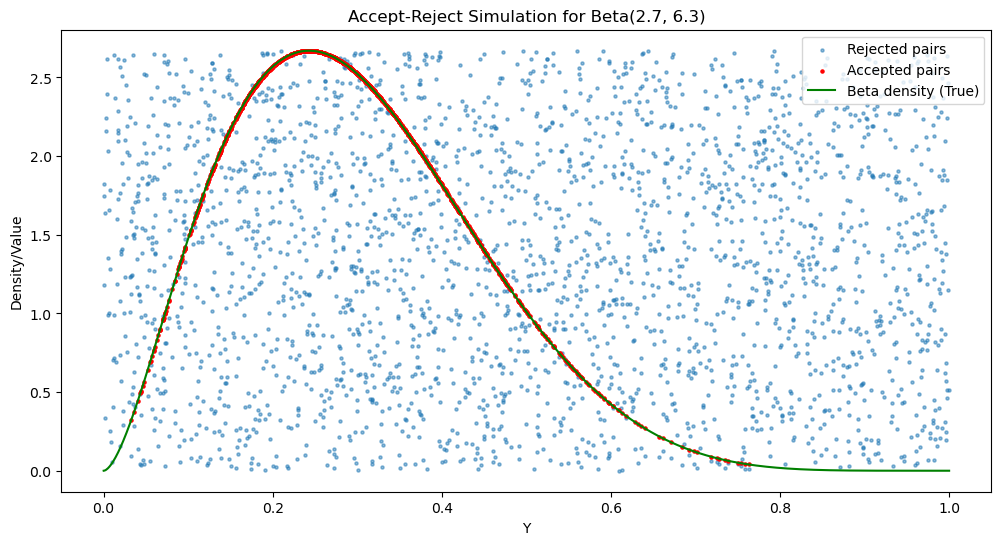

In [1]:

#```python
import random
import scipy.stats as stats
import matplotlib.pyplot as plt

# Parameters for Beta distribution
alpha = 2.7  # Shape parameter a
beta = 6.3   # Shape parameter b
m = 2.67     # Maximum of Beta density (precomputed or estimated)

# Accept-Reject Beta simulation
def accept_reject_beta(alpha, beta, m, size=1000):
    accepted_samples = []
    all_y = []
    all_u = []
    while len(accepted_samples) < size:
        y = random.uniform(0, 1)  # Y ~ U(0, 1)
        u = random.uniform(0, m)  # U ~ U(0, m)
        all_y.append(y)
        all_u.append(u)
        if u < stats.beta.pdf(y, alpha, beta):
            accepted_samples.append(y)
    return accepted_samples, all_y, all_u

# Generate samples
samples, all_y, all_u = accept_reject_beta(alpha, beta, m)

# Plotting
x = [i / 1000 for i in range(1001)]
true_density = stats.beta.pdf(x, alpha, beta)

plt.figure(figsize=(12, 6))
plt.scatter(all_y, all_u, s=5, alpha=0.5, label="Rejected pairs")
plt.scatter(samples, [stats.beta.pdf(y, alpha, beta) for y in samples], s=5, color='red', label="Accepted pairs")
plt.plot(x, true_density, 'g-', label="Beta density (True)")
plt.title(f"Accept-Reject Simulation for Beta({alpha}, {beta})")
plt.xlabel("Y")
plt.ylabel("Density/Value")
plt.legend()
plt.show()


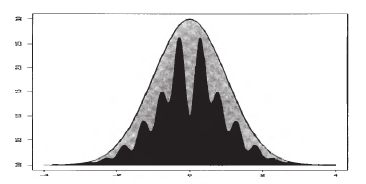

### Generalized Accept-Reject Methods

The method described earlier can be extended to more complex cases where the larger set $ L $ is not a simple box, as long as simulating uniformly over this larger set is feasible. This generalization accommodates scenarios where:
- The support of $ f(x) $ or the maximum of $ f(x) $ is unbounded.
- The set $ L $ takes the form $ L = \{(y, u) : 0 < u < m(y)\} $, where $ m(x) \geq f(x) $ and uniform sampling over $ L $ is feasible.

#### Key Constraints
1. $ m(x) \geq f(x) $: The function $ m(x) $ must bound $ f(x) $ from above.
2. $ m(x) $ is integrable: Ensures that $ m(x) $ has finite mass and allows for uniform sampling on $ L $.

To achieve efficient simulation, $ m(x) $ should be as close as possible to $ f(x) $ to minimize wasted simulations.

#### Representation of $ m(x) $
Since $ m(x) $ cannot be a probability density, it is written as:
$$
m(x) = M g(x),
$$
where:
- $ g(x) $ is a probability density function.
- $ M $ is a scaling constant:
$$
M = \int m(x) \, dx = \int M g(x) \, dx.
$$

#### Simulation Approach
To simulate a uniform random pair $(Y, U)$ over $ L $:
1. Generate $ Y \sim g(x) $.
2. Generate $ U \sim U(0, M g(Y)) $.
3. Accept $ Y $ if \( U < f(Y) $.

The accepted values of $ Y $, now denoted $ X $, follow the desired distribution $ f(x) $.

#### Generalized Acceptance Probability
The probability of accepting a sample is:
$$
P(\text{Accept}) = \frac{1}{M} \int_a^b f(x) \, dx = \frac{1}{M}.
$$

#### Implementation Steps
The generalized algorithm is as follows:
1. Simulate $ Y \sim g(x) $, where $ g(x) $ is a probability density function.
2. Simulate $ U \sim U(0, M g(Y)) $.
3. Accept $ Y $ as $ X $ if $ U < f(Y) $.
4. Repeat until the desired number of samples is generated.

---

### Example: Visualization of Generalized Accept-Reject Sampling
Below is an example visualization for the generalized Accept-Reject method applied to a Beta distribution.



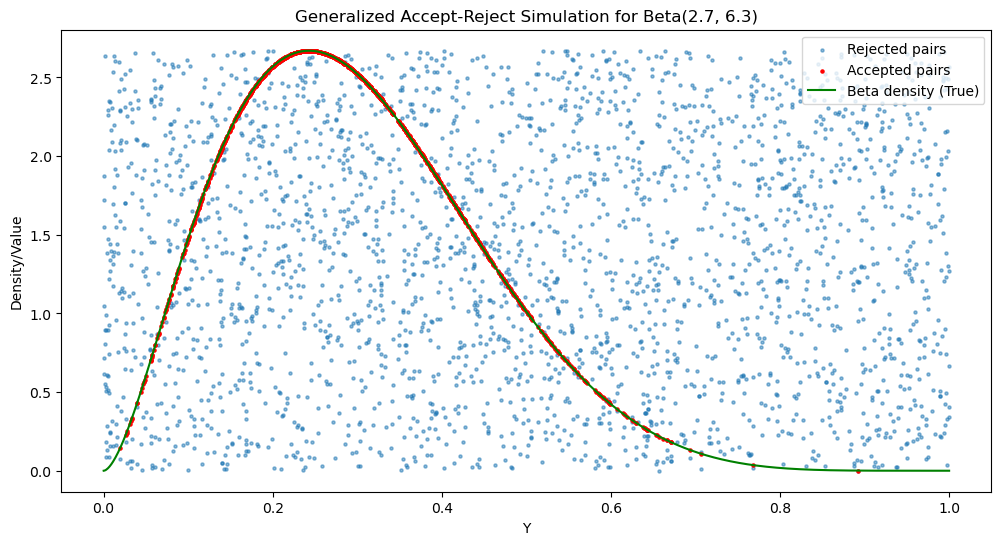

In [3]:
import random
import scipy.stats as stats
import matplotlib.pyplot as plt

# Parameters for Beta distribution
alpha = 2.7  # Shape parameter a
beta = 6.3   # Shape parameter b
M = 2.67     # Maximum of Beta density (precomputed or estimated)

# Generalized Accept-Reject Beta simulation
def generalized_accept_reject_beta(alpha, beta, M, size=1000):
    accepted_samples = []
    all_y = []
    all_u = []
    while len(accepted_samples) < size:
        # Simulate Y ~ Uniform(0, 1) as g(x)
        y = random.uniform(0, 1)
        
        # Simulate U ~ Uniform(0, M * g(y)), where g(y) = 1 (Uniform density)
        u = random.uniform(0, M)
        
        all_y.append(y)
        all_u.append(u)
        
        # Accept if U < f(Y)
        if u < stats.beta.pdf(y, alpha, beta):
            accepted_samples.append(y)
    
    return accepted_samples, all_y, all_u

# Generate samples
samples, all_y, all_u = generalized_accept_reject_beta(alpha, beta, M)

# Plotting
x = [i / 1000 for i in range(1001)]
true_density = stats.beta.pdf(x, alpha, beta)

plt.figure(figsize=(12, 6))
plt.scatter(all_y, all_u, s=5, alpha=0.5, label="Rejected pairs")
plt.scatter(samples, [stats.beta.pdf(y, alpha, beta) for y in samples], s=5, color='red', label="Accepted pairs")
plt.plot(x, true_density, 'g-', label="Beta density (True)")
plt.title(f"Generalized Accept-Reject Simulation for Beta({alpha}, {beta})")
plt.xlabel("Y")
plt.ylabel("Density/Value")
plt.legend()
plt.show()


### Corollary : Generalized Simulation Using an Envelope Function

#### Statement
Let $ X \sim f(x) $ and let $ g(x) $ be a density function that satisfies:
$$
f(x) \leq M g(x),
$$
for some constant $ M \geq 1 $. To simulate $ X \sim f(x) $, it is sufficient to:
1. Generate $ Y \sim g(x) $, where $ g(x) $ is a probability density function.
2. Generate $ U \sim U(0, M g(Y)) $, conditioned on $ Y = y $.
3. Accept $ Y $ as $ X $ if:
$$
U < f(Y).
$$

This method avoids the need for the normalizing constant of $ f(x) $, as only the ratio $ f(x)/M $ is required. 

#### Example: Simulating from a Complex Target Density
Consider the target density:
$$
f(x) \propto \exp(-x/2) \left(\sin^2(6x) + 3 \cos^2(x) \sin^2(4x) + 1\right),
$$
with an upper bound given by the normal density:
$$
g(x) = \frac{\exp(-x^2/2)}{\sqrt{2 \pi}},
$$
where $ M $ is chosen such that $ M g(x) \geq f(x) $ for all $ x $.

#### Algorithm
1. Define the target density $ f(x) $ (up to a multiplicative constant).
2. Use $ g(x) $, a normal distribution, as the envelope function.
3. Choose $ M $ such that $ M g(x) $ bounds $ f(x) $.
4. Apply the Accept-Reject procedure to generate samples.

---

### Implementation
Below is the Python implementation of the described method:



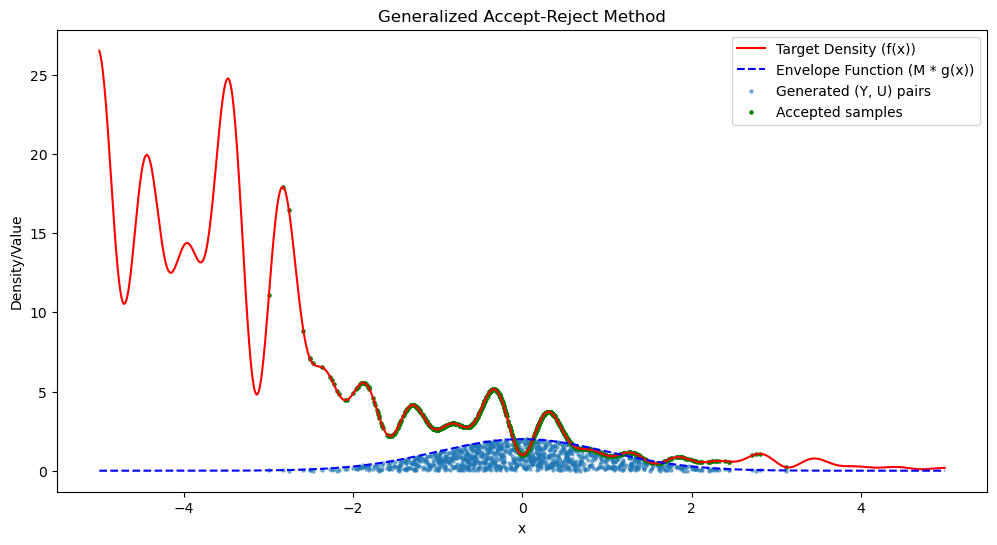

In [4]:
#```python
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the target density (up to proportionality constant)
def target_density(x):
    return math.exp(-x / 2) * (math.sin(6 * x)**2 + 3 * math.cos(x)**2 * math.sin(4 * x)**2 + 1)

# Define the envelope density (standard normal distribution)
def envelope_density(x):
    return norm.pdf(x)  # g(x) = exp(-x^2 / 2) / sqrt(2 * pi)

# Define the envelope scaling factor M
M = 5  # Chosen to satisfy f(x) <= M * g(x) for all x

# Generalized Accept-Reject Sampling
def generalized_accept_reject(size):
    samples = []
    all_y = []
    all_u = []
    while len(samples) < size:
        # Generate Y ~ g(x), standard normal distribution
        y = random.gauss(0, 1)
        
        # Generate U ~ U(0, M * g(Y))
        u = random.uniform(0, M * envelope_density(y))
        
        all_y.append(y)
        all_u.append(u)
        
        # Accept if U < f(Y)
        if u < target_density(y):
            samples.append(y)
    
    return samples, all_y, all_u

# Generate samples
num_samples = 1000
samples, all_y, all_u = generalized_accept_reject(num_samples)

# Plotting the results
x_vals = [i / 100 for i in range(-500, 500)]
f_vals = [target_density(x) for x in x_vals]
g_vals = [M * envelope_density(x) for x in x_vals]

plt.figure(figsize=(12, 6))
plt.plot(x_vals, f_vals, 'r-', label="Target Density (f(x))")
plt.plot(x_vals, g_vals, 'b--', label="Envelope Function (M * g(x))")
plt.scatter(all_y, all_u, s=5, alpha=0.5, label="Generated (Y, U) pairs")
plt.scatter(samples, [target_density(x) for x in samples], s=5, color='green', label="Accepted samples")
plt.title("Generalized Accept-Reject Method")
plt.xlabel("x")
plt.ylabel("Density/Value")
plt.legend()
plt.show()
